In [1]:
import pickle
import os.path
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.qparser import QueryParser
from whoosh import qparser
import random
from nltk.corpus import stopwords
import nltk
import glob
import asr.align
import os
import soundfile as sf
from python_speech_features import mfcc
from python_speech_features import fbank
import lshknn
import numpy as np
import fnmatch
import json
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from numpy import cumsum
import seaborn as sns

In [7]:
audioFileLocation = '/home/ubuntu/DevData-AudioBooks/dev-clean/'
queryAudioLocation = '/home/ubuntu/spokenkeywordsearch/GroundTruth/'
encodingLocation = '/home/ubuntu/model_encoding/'
MFCC = "mfcc"
Encoding = "encoding"

In [11]:
class indexer():
    def __init__(self):
        self.transDict = pickle.load(open('transDict2', 'r'))
        self.convertedDict = pickle.load(open('speechRecConvertDict2', 'r'))
        self.queryList = pickle.load(open('queryList2', 'r'))
        self.queryConvertedDict = pickle.load(open('queryConvertedDict2', 'r'))
        schema = Schema(audio=TEXT(stored=True), content=TEXT)
        if not os.path.exists("index"):
            os.mkdir("index")
        self.index = create_in("index", schema)
        writer = self.index.writer()
        for a in self.transDict:
            writer.add_document(audio=u""+a, content=u""+self.transDict[a])
        writer.commit()
        self.searcher = self.index.searcher()
        
    def getMaxSearch(self):
        maxFoundList = [0]*len(self.queryList)
        diffCount = 0
        for i in range(len(self.queryList)):
            if(self.queryList[i] and self.queryConvertedDict[str(i)]):
                query1 = QueryParser("content", self.index.schema, group=qparser.OrGroup).parse(self.queryList[i])
                result1 = self.searcher.search(query1, limit=None)
                list1 = []
                for res in result1:
                    list1.append(res['audio'])
                maxFoundList[i] = len(list1)
        return maxFoundList
    
    def compareResults(self, indices, distances, audioPosnDict, queryPosnDict, logfileName, limitk):
        log = open(logfileName, 'a')
        print(log)
        totalQueryCount = 0
        totalTrueResults = 0
        totalMatchingResults = 0
        maxMatchingQuery = ""
        maxMatching = 0
        maxFoundList = self.getMaxSearch()
        precisionList = []
        recallList = []
        i = 0
        totalFrames = len(distances)
        while(i<totalFrames):
            samePos = []
            while(i+1<totalFrames and queryPosnDict[i]==queryPosnDict[i+1]):
                samePos.append(i)
                i += 1
            if(len(samePos)==0):
                samePos = [i]
#             else:
#                 i -= 1
            totalQueryCount += 1
            log.write("------------------------------------------------")
            query = self.queryList[int(queryPosnDict[i])]
#             print(str(i) + " " + query)
            log.write("Results for query: " + query +"\n")
            query = QueryParser("content", self.index.schema, group=qparser.OrGroup).parse(query)
            results = self.searcher.search(query, limit=limitk)
            list1 = []
            list2 = []
            for res in results:
                list1.append(res['audio'])
            distanceArr = np.array(distances[samePos[0]:samePos[len(samePos)-1]+1]).flatten()
            indiceArr = np.array(indices[samePos[0]:samePos[len(samePos)-1]+1]).flatten()
            distanceArr = (-distanceArr).argsort()[:min(limitk, len(distanceArr))]
            for d in distanceArr:
                list2.append(audioPosnDict[indiceArr[d]])
#             for ind in samePos:
#                 for k in indices[ind]:
#                     if(audioPosnDict[k]):
#                         log.write(audioPosnDict[k]+" : ")
#                         log.write(self.transDict[str(audioPosnDict[k])] + "\n")
#                         list2.append(audioPosnDict[k])
            comm = len(set(list1).intersection(set(list2)))
            foundCount = len(list2)
            origCount = maxFoundList[int(queryPosnDict[i])]
            if(foundCount>0):
                precisionList.append(float(comm)/float(foundCount))
            else:
                precisionList.append(0.0)
            if(origCount>0):
                recallList.append(float(comm)/float(min(limitk, origCount)))
            else:
                recallList.append(0)
            totalTrueResults += len(list1)
            if(comm>maxMatching):
                maxMatching = comm
                maxMatchingQuery = query
            totalMatchingResults += comm
            log.write("Matching : {0}".format(comm))
            log.flush()
            i += 1
        print("Total queries: ", totalQueryCount)
        print("Total true finds: ", totalTrueResults)
        print("Total matching results: ", totalMatchingResults)
        return precisionList, recallList

In [4]:
class knn_mfcc():
    def __init__(self, featureType, stride, windowSize):
        self.featureType = featureType
        self.stride = stride
        self.windowSize = windowSize
        self.knnnbrs = []
        
    def initializeFeatures(self, featLocation, kind):
        features = []
        posnDict = dict()
        totalFileCount = 0
        frameCount = 0
            
        if(self.featureType == "mfcc"):
            for root, dirnames, filenames in os.walk(featLocation):
                for filename in fnmatch.filter(filenames, '*.wav'):
                    totalFileCount += 1
                    with open(os.path.join(root, filename), 'rb') as f:
                        data, samplerate = sf.read(f)
                    if(kind=="audio"):
                        mfcc_feat = np.array(mfcc(data, samplerate))
                    else:
                        mfcc_feat = np.array(mfcc(data, samplerate, nfft=600))
                    mfcclen = len(mfcc_feat)
                    i = 0
                    lastLen = 0
                    while(i+self.windowSize<mfcclen):
                        features.append(mfcc_feat[i:i+self.windowSize].flatten())
                        lastLen = len(mfcc_feat[i:i+self.windowSize].flatten())
                        posnDict[frameCount] = filename.split('.')[0]
                        i += self.stride
                        frameCount += 1
#                     if(i<mfcclen):
#                         features.append(mfcc_feat[i:mfcclen].flatten()  [0]*(lastLen-(mfcclen-i)))
                        
        elif(self.featureType == "encoding"):
            if(kind=="audio"):
                fileType = '*.flac.json'
            else:
                fileType = '*.wav.json'
            for root, dirnames, filenames in os.walk(featLocation):
                for filename in fnmatch.filter(filenames, fileType):
                    totalFileCount += 1
                    curr = np.array(json.load(open(root+filename, 'r')))
                    for c in curr:
                        features.append(c)
                        posnDict[frameCount] = filename.split('.')[0]
                        frameCount += 1
        return features, posnDict
    
    def initKNN(self, k, knnalgorithm, audioFeatures):
        self.knnnbrs = NearestNeighbors(n_neighbors=k, algorithm=knnalgorithm).fit(audioFeatures)
        
    def searchForQuery(self, queryFeatures):
        return self.knnnbrs.kneighbors(queryFeatures)

In [6]:
def getResults(featureType, stride, windowSize, ks):
    knnObj = knn_mfcc(featureType, stride, windowSize)
    audioFeatures, audioPosnDict = knnObj.initializeFeatures(audioFileLocation, "audio")
    print(len(audioFeatures))
    queryFeatures, queryPosnDict = knnObj.initializeFeatures(queryAudioLocation, "query")
    print(len(queryFeatures))
    
    for kt in ks:
        print("----------------"+str(kt)+"-------------------------")
        knnObj.initKNN(kt, "ball_tree", audioFeatures)
        print("Done initKNN")
        nndistances, nnindices = knnObj.searchForQuery(queryFeatures)
        print("Done finding nearest neighbors")
        resultchecker = indexer()
        precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', kt)
        try:
            sns.distplot(precisionList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="Precision")
        except ImportError:
            doNothing = 0
        plt.label("CDF of precision @ k="+str(kt))
        plt.show()
        try:
            sns.distplot(recallList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="Recall")
        except ImportError:
            doNothing = 0
        plt.label("CDF of recall @ k="+str(kt))
        plt.show()

In [8]:
getResults(MFCC, 10, 30, [10, 50])

186858
18802
----------------10-------------------------
Done initKNN
Done finding nearest neighbors
<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f6608cf4ed0>


NameError: global name 'nndistances' is not defined

In [12]:
# Using MFCC Features
knnObj = knn_mfcc("mfcc", 10, 30)
audioFeatures, audioPosnDict = knnObj.initializeFeatures(audioFileLocation, "audio")
print(len(audioFeatures))
# print(len(audioPosnDict))
queryFeatures, queryPosnDict = knnObj.initializeFeatures(queryAudioLocation, "query")
print(len(queryFeatures))
# print(len(queryPosnDict))

186858
18802


In [ ]:
# knnObj.initKNN(10, "ball_tree", audioFeatures)
# print("Done initKNN")
nndistances, nnindices = knnObj.searchForQuery(queryFeatures)
print("Done finding nearest neighbors")
resultchecker = indexer()
precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', 10)

In [79]:
resultchecker = indexer()
precisionList, recallList =resultchecker.compareResults(nnindices, nndistances, audioPosnDict, queryPosnDict, 'mfccFeaturek10.txt', 10)

<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f024071eed0>
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 649)


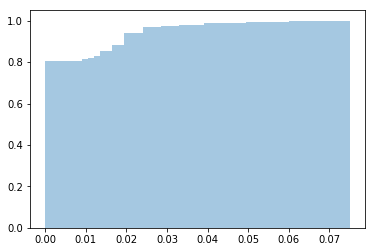

In [80]:
try:
    sns.distplot(precisionList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

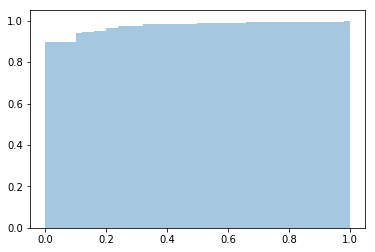

In [81]:
try:
    sns.distplot(recallList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

In [6]:
# Using Encoding features
knnEncObj = knn_mfcc("encoding", 10, 30)
audioEncFeatures, audioEncPosnDict = knnEncObj.initializeFeatures(encodingLocation, "audio")
print(len(audioFeatures))
# print(len(audioPosnDict))
queryEncFeatures, queryEncPosnDict = knnEncObj.initializeFeatures(encodingLocation, "query")
print(len(queryFeatures))
# print(len(queryPosnDict))

190833
190833
2703
2703


In [50]:
# Using Encoding features
# k = 10
# knnEncObj.initKNN(k, "ball_tree", audioEncFeatures)
# print("Done initKNN")
# nnEncDistances, nnEncIndices = knnEncObj.searchForQuery(queryEncFeatures)
# print(len(nndistances))
# print("Done finding nearest neighbors")
resultchecker = indexer()
precisionList, recallList = resultchecker.compareResults(nnEncIndices, nnEncDistances, audioEncPosnDict, queryEncPosnDict, 'mfccFeaturek10.txt', k)

<open file 'mfccFeaturek10.txt', mode 'a' at 0x7f023f945420>
('Total queries: ', 2703)
('Total true finds: ', 16920)
('Total matching results: ', 84)


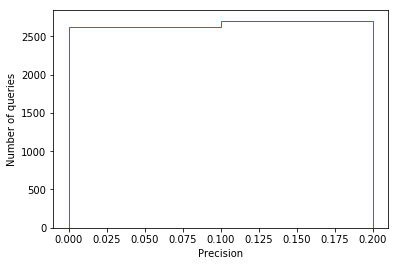

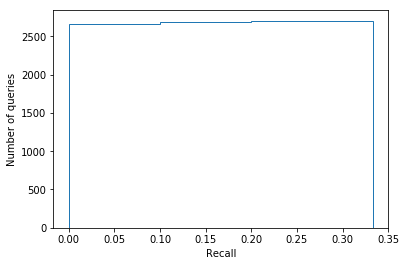

In [70]:
plt.hist(precisionList, cumulative=True, histtype='step')
plt.xlabel("Precision")
plt.ylabel("Number of queries")
plt.show()

plt.hist(recallList, cumulative=True, histtype='step')
plt.xlabel("Recall")
plt.ylabel("Number of queries")
plt.show()

In [56]:
print(precisionCDF)

[0.  0.  0.  ... 8.4 8.4 8.4]


In [51]:
print(precisionList)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

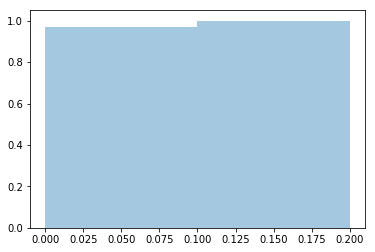

In [73]:
try:
    sns.distplot(precisionList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

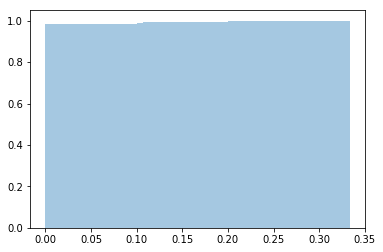

In [75]:
try:
    sns.distplot(recallList, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
except ImportError:
    doNothing = 0

array([1, 2, 3, 4])